# Data Visualization

### imports

In [9]:
from audio_segmentation.concat_audio import produce_final_audio
from audio_segmentation.split_audio import produce_audio_snippets
from db_connect import db_get_df
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import mutagen.mp3
import os
from tqdm import tqdm

load_dotenv()
audiofile_path = os.getenv("AUDIO_SOURCE_PATH")

In [ ]:
df = db_get_df(table="transcripts_all")
print(len(df))
print(df.dtypes)

Wir verwenden hier das Deutsche model, um die deutschen Transkripte optimal zu encodieren.

### Audio file length

In [2]:
def get_mp3_lengths(directory):
    mp3_lengths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".mp3"):
                try:
                    file_path = os.path.join(root, file)
                    audio = mutagen.mp3.MP3(file_path)
                    mp3_lengths.append(audio.info.length)
                except:
                    print(f"file {file} corrupted")
    return mp3_lengths

def plot_mp3_lengths(mp3_lengths):
    plt.hist(mp3_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('MP3 Länge (Sekungen)')
    plt.ylabel('Anzahl MP3 Datein')
    plt.title('Länge der MP3 Datein')
    plt.show()

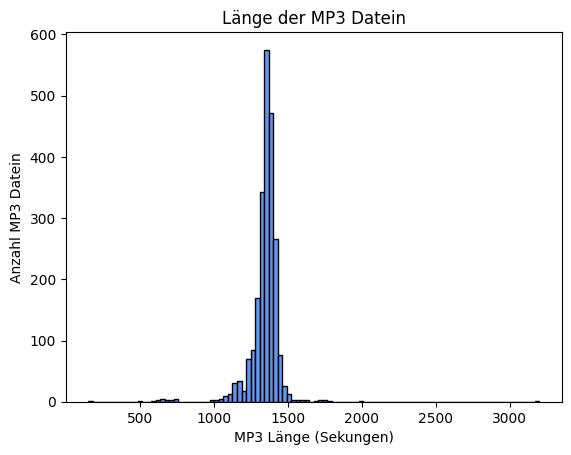

In [5]:
mp3_directory = audiofile_path
mp3_lengths = get_mp3_lengths(mp3_directory)
plot_mp3_lengths(mp3_lengths)


### Transcript length

In [10]:
df = db_get_df(table="transcript_word_level_2237")

In [11]:
len(df)

5429585

In [14]:
filtered_df = df[df['filename'] == 'david-bowie-das-chamaeleon-des-pop.mp3']
filtered_df

,filename,index,word,start,end
2124707,david-bowie-das-chamaeleon-des-pop.mp3,0.0,Radio,1.68,2.40
2124708,david-bowie-das-chamaeleon-des-pop.mp3,1.0,Wissen.,2.40,2.82
2124709,david-bowie-das-chamaeleon-des-pop.mp3,2.0,Die,3.78,3.78
2124710,david-bowie-das-chamaeleon-des-pop.mp3,3.0,ganze,3.78,4.22
2124711,david-bowie-das-chamaeleon-des-pop.mp3,4.0,Welt,4.22,4.60
...,...,...,...,...,...
2127182,david-bowie-das-chamaeleon-des-pop.mp3,2.0,höchstwahrscheinlich.,1389.20,1390.12
2127183,david-bowie-das-chamaeleon-des-pop.mp3,0.0,SWISS,1391.40,1417.96
2127184,david-bowie-das-chamaeleon-des-pop.mp3,1.0,TXT,1417.96,1417.96
2127185,david-bowie-das-chamaeleon-des-pop.mp3,2.0,"AG,",1417.96,1417.96


In [ ]:
def plot_transcript_lengths(transcript_lengths):
    ax = plt.gca()
    ax.set_xlim([1500, 4000])
    plt.hist(transcript_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('Transkript Länge (Wörter)')
    plt.ylabel('Anzahl  Transkripte')
    plt.title('Länge der Trankripte')
    plt.show()

In [ ]:
lengths = []
filenames = df["filename"].drop_duplicates(ignore_index=True)
for filename in tqdm(filenames):
    word_entries = df[df['filename'] == filename]
    lengths.append(len(word_entries))

In [ ]:
plot_transcript_lengths(lengths)

### Länge der Sätze

In [4]:
df = db_get_df(table="transcript_sentences_spacy")

In [5]:
def plot_sentence_lengths(sentence_lengths):
    plt.hist(sentence_lengths, bins=100, color='cornflowerblue', edgecolor='black')
    plt.xlabel('Sätze Länge (Wörter)')
    plt.ylabel('Anzahl  Sätze')
    plt.title('Länge der Sätze')
    plt.show()

In [6]:
df["sentence_lenght"] = df["sentence"].apply(len)
df = df.sort_values(by="sentence_lenght")

In [7]:
df.iloc[-1]["sentence"]

'wir sind nicht das land mit der höchsten inzidenz da ist dänemark slowenien auch italien und frankreich liegen etwas vor uns wobei die zahlen seit 2001 hierzulande kontinuierlich gestiegen sind was unter anderem damit zu tun haben dürfte dass ärztinnen und ärzte heute fälle besser erkennen als früher einige forschende vermuten aber auch dass die alterung der bevölkerung eine rolle spielt ebenso die klimaerwärmung wahrscheinlich kommt die legionärskrankheit bei uns aber noch viel häufiger vor das ergeben jedenfalls hochrechnungen zu pneumonien also zu lungenentzündungen und da kommt man eigentlich dann für deutschland so auf zahlen von 15 bis 30 .000 das heißt das was wir im moment nachweisen ist wirklich nur die spitze des eisbergs allerdings spielte auch eine rolle dass keineswegs alle legionär lab nur wenn ihn hoch dramatisch verlaufen schätzungsweise zwischen zwei und vier prozent aller lungenentzündungen werden durch legionellen verursacht hinzukommen ebenfalls geschätzt jährlich 

In [ ]:
df[df["sentence_lenght"] > 2000]

Logarithmische Normalverteilung

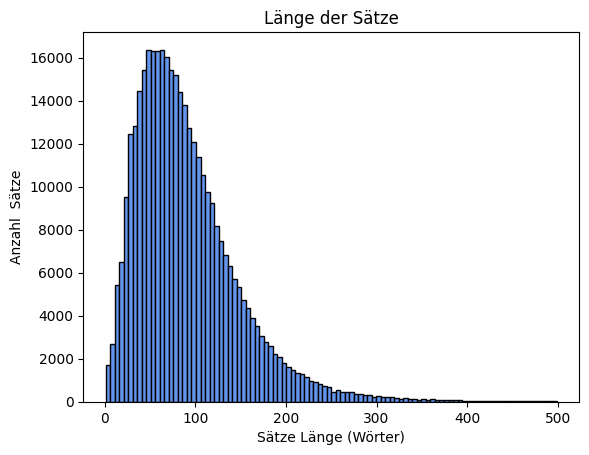

In [8]:
plot_sentence_lengths(df[df["sentence_lenght"] < 500]["sentence_lenght"])

## Anzahl aller Episoden 

In [1]:
import requests 

GRAPHQL_URL = "https://api.ardaudiothek.de/graphql"
def get_graphql(query):
    response = requests.post(GRAPHQL_URL, json={"query": query})
    if response.status_code == 200:
        return response.json()
    else:
        raise f"GraphQL request failed with status code {response.status_code}"

In [ ]:
query = """
{
	shows: programSets(
    filter:{
      numberOfElements:{
        greaterThanOrEqualTo: 0
      }
    }
  )
  {totalCount}
  
items(filter:{isPublished:{equalTo:true}}){
    totalCount
  }
}
"""

## Alle Autoren (nicht sprecher)

In [3]:
query = """
    {
        programSet(id: 5945518) {
        items(
            filter: {
            isPublished: {
                equalTo: true
            }
            }
        ) {
            nodes {
              description
            }
        }
        }
    }
"""

In [4]:
response = get_graphql(query)

In [27]:
[print(autor["description"].split("Autorin: ")[-1].split("Autor: ")[-1]) for autor in response["data"]["programSet"]["items"]["nodes"][:10]]

Frank Schüre
Beate Meierfrankenfeld
Karin Lamsfuß (BR 2020)
Daniela Remus
Carola Zinner
Karin Becker
Susanne Hofmann
Beate Meierfrankenfeld (BR 2018)
Martin Trauner (BR 2016)
Ulrike Beck


[None, None, None, None, None, None, None, None, None, None]

In [36]:
from tqdm import tqdm
autors = set()

for node in response["data"]["programSet"]["items"]["nodes"]:
    autor = node["description"]
    if "Autor: " in autor or "Autorin: " in autor:
        autor = autor.split("Autorin: ")[-1].split("Autor: ")[-1]
        autor = autor.split("(")[0]
    else:
        autor = ""
    autors.add(autor)

print(len(autors))

257


## Einzelne Episdoden transkripte analysieren